 # Plots for 'Data over the Kamb channel'
 
 ## Plan

1. overview map
2. REMA splodge
3. ApRES plot
4. radar map
3. icesat2 dots
4. a. Icesat2 crosssection lower
4. b. Icesat2 crosssection raise
5. a. Icesat1 and REMA crossections
5. b. other icesat1 and REMA

In [1]:
import rasterio as rio
import rasterio.mask
import fiona
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr
from shapely.geometry import Point, LineString, box
# import cartopy.crs as crs
# import hvplot.pandas
import tarfile

In [2]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

# a = 5000

# xmin= xmin- a

# xmax=xmax+ a

# ymin=ymin- a

# ymax = ymax+ a

In [3]:
print(xmin, xmax, ymin, ymax)

-382700 -374781.9 -734075.1 -721770.2


In [4]:
#crop the moa image to larger channel area

# gdal_translate -projwin -392700 -711770.2 -364781.9 -744075.1 -of GTiff /Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa125_2009_hp1_v1.1.tif /Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa_cropped_KIS2.tif

In [5]:
bbox = box(xmin, xmax, ymin, ymax )

In [6]:
xgrid = np.arange(-382000,-374000,2000)
xgrid

array([-382000, -380000, -378000, -376000])

In [7]:
# Load modis moa

# with rio.open('/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/SatelliteImagery/MODIS/MODIS_Mosaic_siplecoast.tif') as image:
#     extent_moa = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     im_moa = image.read(1)
#     window=Window(0, 0, 10000, 10000)
#gdal_translate -projwin -382700.0 -721770.2 -374781.9 -734075.1 -of GTiff /Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa125_2009_hp1_v1.1.tif /Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa_cropped_channel.tif
with rio.open('/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa_cropped_KIS2.tif') as image:
    extent_moa = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_moa = image.read(1)

In [8]:
#APRES
# df = pd.read_csv('/Users/home/whitefar/CODE/apres/KIS2_ApresResults.csv')
# df = df.sort_values('x')
df = pd.read_csv('/Users/home/whitefar/DATA/ApRES/kis2_meltrates.csv').query('(Epoch == 3) & (~meltRate.isna())', engine='python')
points = [Point(xy) for xy in zip(df.x,df.y) ]
apres_gdf = gpd.GeoDataFrame(df,geometry=points,crs=3031)
del df


In [9]:
apres_winter = apres_gdf.query('Site_ID=="CP14"').copy()

In [10]:
radarlines_paths = sorted(glob.glob("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/*.shp"))
toremove = ['/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line0KIS1.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line0bKIS1.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/lineseis34.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/left1011.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/left1213.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/left1415.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line9.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right1112.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right13.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right1314.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/right910.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line10.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line11.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line12.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line13.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line14.shp',
            '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line7.shp']                        
for i in toremove:
    radarlines_paths.remove(i)
radarlines_paths.append('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/line7.gpkg')

radarlines = [gpd.read_file(radarline) for radarline in radarlines_paths]

In [11]:
lines = [os.path.splitext(os.path.split(pp)[1])[0] for pp in radarlines_paths]

In [12]:
radarlines_dict = dict(zip(lines,radarlines))


In [13]:
!ls /Volumes/arc_02/REMOTE_SENSING/ICESAT2/ATLAS/ATLXI/

20201111		       ds_subset_kamb_20200513.nc
20201224		       ds_subset_kamb_20200716.nc
ds_subset_kamb_20200404.nc     ds_subset_kamb_20201111.nc
ds_subset_kamb_20200404_v2.nc  ds_subset_kamb.nc


In [14]:
#/Volumes/arc_02/REMOTE_SENSING/ICESAT2/ds_subset_kamb.nc
icesat2_df = xr.open_dataset("/Volumes/arc_02/REMOTE_SENSING/ICESAT2/ATLAS/ATLXI/ds_subset_kamb_20201111.nc", engine="h5netcdf").drop_dims(['poly_exponent_x','poly_exponent_y']).to_dataframe().query("x > -382064.5722209641 & x < -374781.1654740692 & y > -734075.0820404041 & y < -722764.4514729496 & cycle_number == 3")

In [15]:
icesat1_path = "/Users/home/whitefar/DATA/REMOTE_SENSING/ICESAT1/shapefiles_of_icesat1_over_channel/"
icesat1_gdf = pd.concat([gpd.read_file(icesat1_path+"track0099smoothpoints.shp"),
                         gpd.read_file(icesat1_path+"track0211smoothpoints.shp") ] )

In [16]:
reference_line =  gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/SHARE_SHAPEFILES/interpolated_channel_mid.shp')

In [17]:
#groundingline
groundingline_path = glob.glob(f"/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/*.shp")[0]
groundingline =  gpd.read_file(groundingline_path)
# groundingline_path

groundingline = groundingline[groundingline.geometry.intersects(bbox)].copy()

coast = groundingline.geometry.iloc[0].exterior.coords[:]

gl = np.array([[x,y] for x,y in coast ])

gl = gl[(gl[:,0]< xmax) & (gl[:,0]> xmin) & (gl[:,1] > ymin) & (gl[:,1] <  ymax)].copy()

In [18]:
# extend_by = 1000

# plt.figure(figsize=[25,20])
# plt.imshow(im_moa,extent=extent_moa, vmin=155,vmax=168,cmap='Greys')
# plt.plot(reference_line.geometry.x,reference_line.geometry.y,'y-',label='Channel High')
# plt.plot(REMA_bullseye[0],REMA_bullseye[1],'--',label='REMA downwasting')
# plt.plot(apres_gdf.x,apres_gdf.y,'*',label='APRES locations')
# plt.plot(icesat2_df.x,icesat2_df.y,'1',label='ICESAT2 points')
# plt.plot(icesat1_gdf.x,icesat1_gdf.y,'+',label='ICESAT1 points')
# for i,rl in enumerate(radarlines):
#     if i ==0:
#         plt.plot(rl.geometry.x,rl.geometry.y,':',label='radar profiles')
#     else:
#         plt.plot(rl.geometry.x,rl.geometry.y,':')
# plt.xlim([-382064 - extend_by, -374781 + extend_by])
# plt.ylim([-734075.0820404041 - extend_by,-722764.4514729496 + extend_by]) 
# plt.legend()
# plt.colorbar()
# plt.show()

In [19]:
#load REMA
# nid1 = 159202
# nid2 = 131226
# df = gpd.read_file('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/REMA_Strip_Index_Rel1/REMA_Strip_Index_Rel1.shp')
# # path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
# f = df.loc[nid1].acquisitio
# t =df.loc[nid2].acquisitio
# duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
# # with rio.open(path) as image:
# #     im = image.read(1)
# #     im[im==-9999] = np.nan
# #     im = im / duration
# with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
#     extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     im_REMA = image.read(1)/100

In [20]:
# geometry = [Point(-152.4735,-82.46675)]

In [21]:
# apres20 =gpd.GeoDataFrame({"ApRES2020":geometry},geometry=geometry,crs=4326)
# apres20 = apres20.to_crs(3031).copy()
# apres20.geometry.x

In [22]:
geometryds = [Point(-152.29144,-82.47048)]
ds =gpd.GeoDataFrame({"ApRES2020":geometryds},geometry=geometryds,crs=4326)
ds = ds.to_crs(3031).copy()
ds.geometry.x

0   -380922.093608
dtype: float64

In [23]:
yticks = (np.linspace(-734000,-722000,4)/1000).astype(int)
xticks = (np.linspace(-382000,-376000,4)/1000).astype(int)

In [24]:
# a = {'KIS2':Point(2.47048, -152.29144)}
# KIS2 = gpd.GeoDataFrame({a,geometry=a,crs=4041)

In [25]:
letters_placement = [[-381.0, -724],
                     [-380.7, -724.1],
                     [-380.4, -724.2],
                     [-378.4, -724],
                     [-378.1, -724.1],
                     [-377.8, -724.2],
                     [-377.3, -724],
                     [-377, -724.1],
                     [-376.7, -724.2]
                    ]

In [26]:
alpha = 0.8

In [27]:
radarlines[0].keys()

Index(['timestamp', 'height', 'dt', 'velocity', 'acc', 'dx', 'distan_cum',
       'nid_122088', 'nid_131225', 'nid_131226', 'nid_131228', 'nid_159199',
       'nid_159200', 'nid_159202', 'geometry'],
      dtype='object')

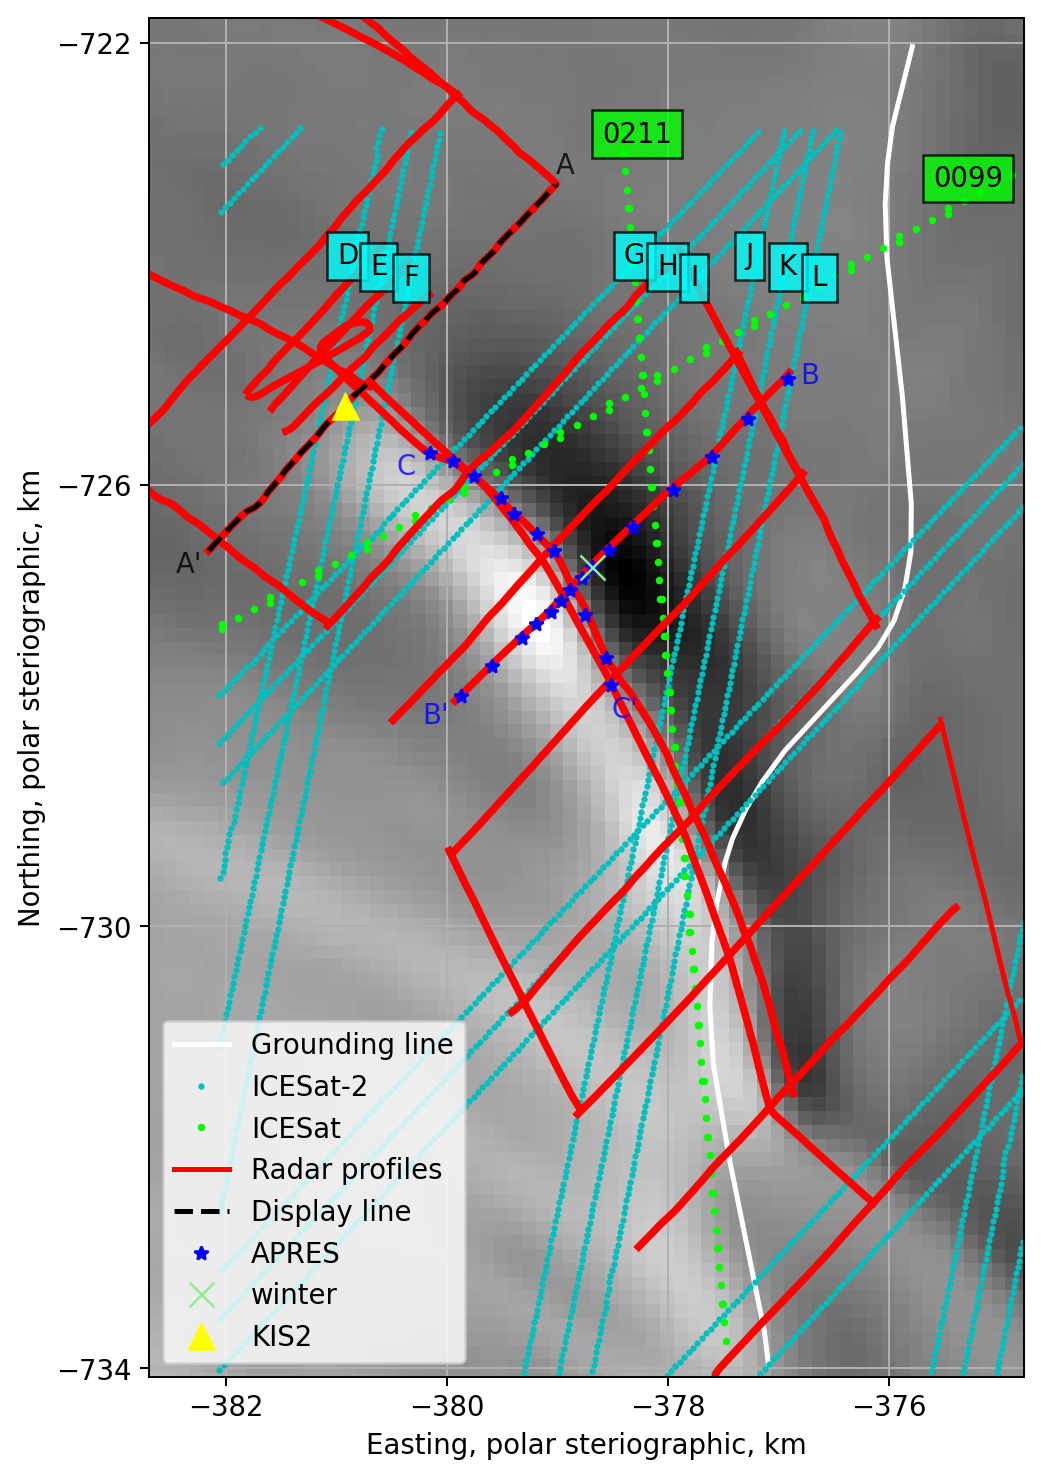

In [31]:
plt.figure(figsize=[7,10],dpi=180)
plt.imshow(im_moa,extent=np.array(extent_moa)/1000,cmap='gist_gray')
# plt.plot(REMA_bullseye[0],REMA_bullseye[1],'--',label='REMA downwasting')

plt.rcParams.update({'font.size': 11})


plt.plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='Grounding line',linewidth=2)

#icesat2
plt.plot(icesat2_df.x/1000,icesat2_df.y/1000,'c.',label='ICESat-2',markersize=3)
i=65
for x,y in letters_placement:
    plt.text(x,y,chr(i+3),bbox=dict(facecolor='cyan', alpha=alpha))
    i += 1

plt.plot(icesat1_gdf.x/1000,icesat1_gdf.y/1000,'.',markersize=4,label='ICESat',color='lime')
plt.text(-378.6, -722.9,'0211',bbox=dict(facecolor='lime', alpha=alpha))
plt.text(-375.6, -723.3,'0099',bbox=dict(facecolor='lime', alpha=alpha))
for i,rl in enumerate(radarlines):
    if i ==0:
        plt.plot(rl.geometry.x/1000,rl.geometry.y/1000,'r-',label='Radar profiles',linewidth=2)
    else:
        plt.plot(rl.geometry.x/1000,rl.geometry.y/1000,'r-',linewidth=3)
        
plt.plot(radarlines_dict['line7'].geometry.x/1000,radarlines_dict['line7'].geometry.y/1000,'k--',linewidth=2,label='Display line')
plt.text(radarlines_dict['line7'].iloc[0].geometry.x/1000-0.3,radarlines_dict['line7'].iloc[0].geometry.y/1000-0.2,"A'", alpha=alpha)
plt.text(radarlines_dict['line7'].iloc[-1].geometry.x/1000,radarlines_dict['line7'].iloc[-1].geometry.y/1000+0.1,'A', alpha=alpha)



plt.plot(apres_gdf.x/1000,apres_gdf.y/1000,'b*',
         #color='fuchsia',
         label='APRES',markersize=6)
plt.plot(apres_winter.geometry.x/1000,apres_winter.geometry.y/1000,'x',
         color='lightgreen',
         label='winter',markersize=10)
plt.text(apres_gdf.iloc[-1].geometry.x/1000-0.3,apres_gdf.iloc[-1].geometry.y/1000-0.2,"C",color='b', alpha=alpha)
plt.text(apres_gdf.loc[48].geometry.x/1000,apres_gdf.loc[48].geometry.y/1000-0.3,"C'",color='b', alpha=alpha)

plt.text(radarlines_dict['lineAPREScross'].iloc[-1].geometry.x/1000-0.3,radarlines_dict['lineAPREScross'].iloc[-1].geometry.y/1000-0.2,"B'",color='b', alpha=alpha)
plt.text(radarlines_dict['lineAPREScross'].iloc[0].geometry.x/1000+0.1,radarlines_dict['lineAPREScross'].iloc[0].geometry.y/1000-0.1,'B',color='b', alpha=alpha)


plt.plot(ds.geometry.x/1000,ds.geometry.y/1000,"^",color='yellow',
         #color='fuchsia',
         label='KIS2',markersize=10)

ap = 7


plt.xlim([xmin/1000, xmax/1000])
plt.ylim([ymin/1000, ymax/1000]) 
plt.xlabel('Easting, polar steriographic, km')
plt.ylabel('Northing, polar steriographic, km')
plt.xticks(xticks)
plt.yticks(yticks)
plt.grid()
plt.legend(
    #bbox_to_anchor=(0.75, 1.15)
            )



plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/geophysics_overview.png')
plt.show()

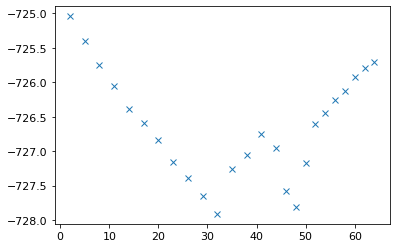

In [29]:
plt.plot(apres_gdf.geometry.y/1000,'x')

In [111]:
apres_gdf.geometry.y

2    -725040.587145
5    -725404.349099
8    -725753.993767
11   -726050.188140
14   -726385.170633
17   -726592.526309
20   -726840.809741
23   -727156.028568
26   -727387.003507
29   -727646.001902
32   -727911.444776
35   -727263.504501
38   -727055.933839
41   -726749.438843
44   -726957.237353
46   -727571.538731
48   -727810.027831
50   -727175.883426
52   -726604.090665
54   -726449.424749
56   -726261.391547
58   -726125.125054
60   -725922.276420
62   -725789.832164
64   -725711.758591
dtype: float64

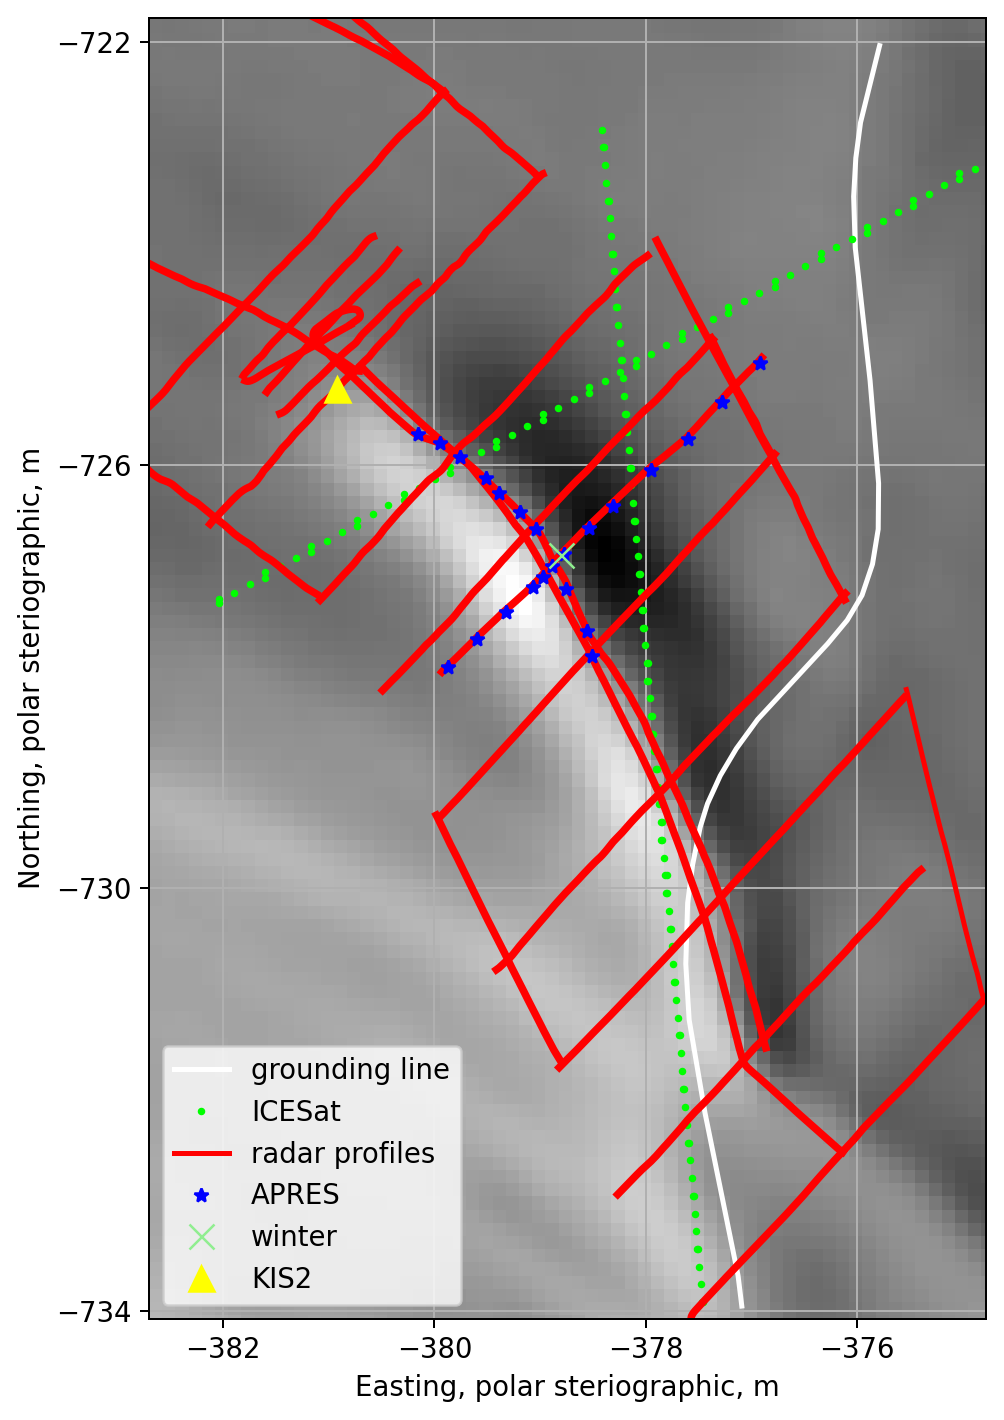

In [41]:
plt.figure(figsize=[6,10],dpi=180)
plt.imshow(im_moa,extent=np.array(extent_moa)/1000,cmap='gist_gray')
# plt.plot(REMA_bullseye[0],REMA_bullseye[1],'--',label='REMA downwasting')

plt.rcParams.update({'font.size': 11})


plt.plot(gl[:,0]/1000,gl[:,1]/1000,'w-',label='grounding line',linewidth=2)

#icesat2
# plt.plot(icesat2_df.x/1000,icesat2_df.y/1000,'c.',label='ICESat-2',markersize=3)
i=65
# for x,y in letters_placement:
#     plt.text(x,y,chr(i),bbox=dict(facecolor='cyan', alpha=alpha))
#     i += 1

plt.plot(icesat1_gdf.x/1000,icesat1_gdf.y/1000,'.',markersize=4,label='ICESat',color='lime')
# plt.text(-378.6, -722.9,'0211',bbox=dict(facecolor='lime', alpha=alpha))
# plt.text(-375.6, -723.3,'0099',bbox=dict(facecolor='lime', alpha=alpha))
for i,rl in enumerate(radarlines):
    if i ==0:
        plt.plot(rl.geometry.x/1000,rl.geometry.y/1000,'r-',label='radar profiles',linewidth=2)
    else:
        plt.plot(rl.geometry.x/1000,rl.geometry.y/1000,'r-',linewidth=3)
# plt.plot(apres20.geometry.x,apres20.geometry.y,'o',label='winter APRES, GNSS',color='orchid')

plt.plot(apres_gdf.x/1000,apres_gdf.y/1000,'b*',
         #color='fuchsia',
         label='APRES',markersize=6)
plt.plot(apres20.geometry.x/1000,apres20.geometry.y/1000,'x',
         color='lightgreen',
         label='winter',markersize=10)
plt.plot(ds.geometry.x/1000,ds.geometry.y/1000,"^",color='yellow',
         #color='fuchsia',
         label='KIS2',markersize=10)

ap = 7


plt.xlim([xmin/1000, xmax/1000])
plt.ylim([ymin/1000, ymax/1000]) 
plt.xlabel('Easting, polar steriographic, m')
plt.ylabel('Northing, polar steriographic, m')
plt.xticks(xticks)
plt.yticks(yticks)
plt.grid()
plt.legend(
    #bbox_to_anchor=(0.75, 1.15)
            )



# plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/geophysics_overview.png')
plt.show()

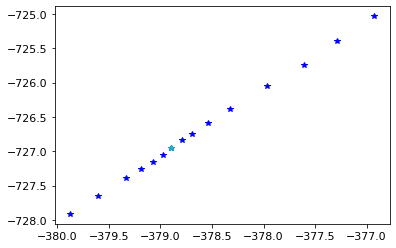

In [38]:
plt.plot(apres_gdf.x/1000,apres_gdf.y/1000,'b*',
         #color='fuchsia',
         label='APRES',markersize=6)
ap = 6
plt.plot(apres_gdf.x.iloc[ap]/1000,apres_gdf.y.iloc[ap]/1000,'c*',
         #color='fuchsia',
         label='APRES',markersize=6)

In [4]:
3+5*12

63